In [1]:
import sys
sys.path.append('../../../../../ClusterMap')
sys.path.append('../../../scripts/')

In [3]:
from ClusterMap.clustermap import *
from seg_utils import create_xenium_dapi_mask
from paths import get_data_paths

from joblib import Parallel, delayed
import matplotlib.pyplot as plt
import numpy as np
import math
import pandas as pd
import tifffile
from skimage import io as sio

%matplotlib inline

## Load data

In [7]:
filepath = get_data_paths('../../../data_mapping.yml')['human_ovarian_cancer']

### DAPI

In [8]:
dapi = sio.imread(f'{filepath}/morphology_focus/morphology_focus_0000.ome.tif')[:,:,0]

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


In [5]:
dapi_mask = create_xenium_dapi_mask(filepath, scale=0.2125, shape=dapi.shape)

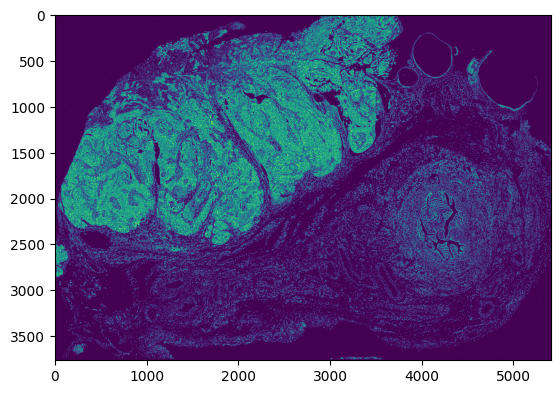

In [6]:
plt.imshow(dapi_mask[::10, ::10])
plt.show()

### Spots

In [32]:
spots = pd.read_parquet(f'{filepath}/subset/transcripts.parquet')
spots = spots[['feature_name', 'x_location', 'y_location']]
spots.columns=['gene_name','spot_location_1','spot_location_2']
spots['gene'] = pd.factorize(spots['gene_name'])[0] + 1

spots[['spot_location_1','spot_location_2']] /= 0.2125
spots[['spot_location_1','spot_location_2']] = spots[['spot_location_1','spot_location_2']].astype(int)

### save gene annotation as genelist.csv
# genes.to_csv(filepath+'genelist.csv', header=False, index=False)

spots.head()

,gene_name,spot_location_1,spot_location_2,gene
132387431,A2ML1,40144,21640,1
132387432,A2ML1,40373,22323,1
132387433,AAMP,40318,21698,2
132387434,AAMP,40323,22330,2
132387435,AAMP,40467,22008,2


In [33]:
x_min, x_max = (spots.spot_location_1.min(), spots.spot_location_1.max())
y_min, y_max = (spots.spot_location_2.min(), spots.spot_location_2.max())

In [23]:
dapi = np.array(dapi[y_min:y_max, x_min:x_max])

In [34]:
spots['spot_location_1'] -= x_min
spots['spot_location_2'] -= y_min

In [49]:
spots.reset_index(drop=True, inplace=True)

In [69]:
xy_radius = round(1 / 0.2125)
xy_radius

5

In [70]:
gene_list = np.arange(1, np.max(spots['gene']) + 1)
num_dims = len(dapi.shape)
num_dims

2

## Run ClusterMap using the default DAPI segmentation method

In [77]:
model = ClusterMap(
    spots=spots, dapi=dapi, gene_list=gene_list, num_dims=num_dims,
    xy_radius=xy_radius, z_radius=0, fast_preprocess=True
)

### segment without tiling

In [ ]:
%%time
model.preprocess(dapi_grid_interval=5, pct_filter=0.1)
model.min_spot_per_cell = 5
model.segmentation(cell_num_threshold=100, dapi_grid_interval=3, add_dapi=True, use_genedis=True)

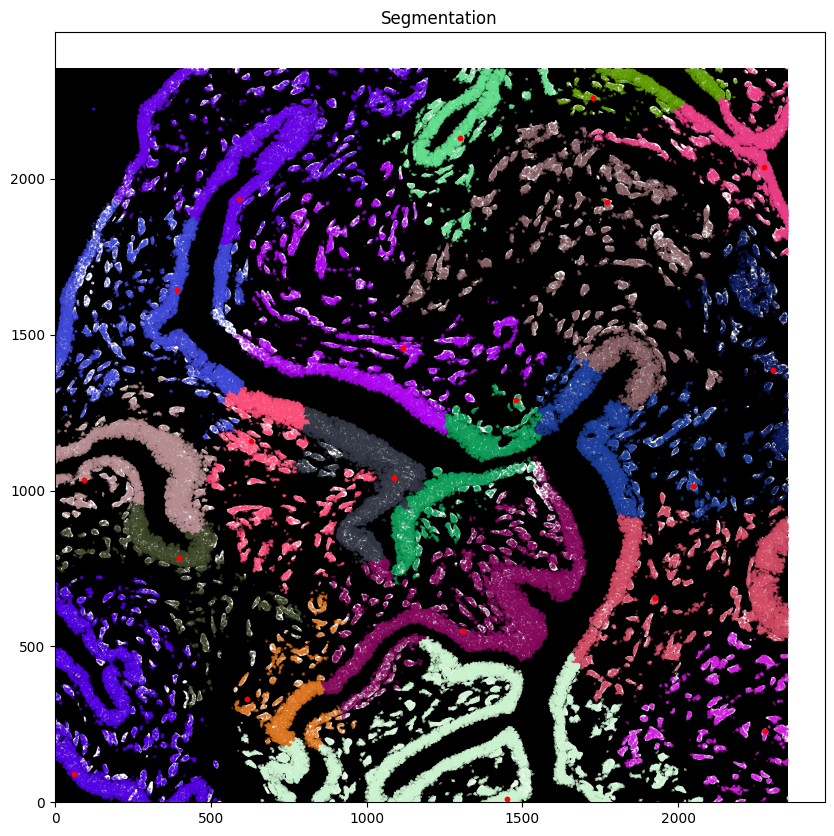

In [79]:
model.plot_segmentation(figsize=(20,10),s=0.05,plot_with_dapi=False,plot_dapi=True, show=False)
plt.scatter(model.cellcenter_unique[:,1],model.cellcenter_unique[:,0],c='r',s=10)
plt.show()

### tiling

In [39]:
%%time
img = dapi
window_size = 3000
label_img = get_img(img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))
out = split(img, label_img, spots, window_size=window_size, margin=math.ceil(window_size*0.1))

Split finished: 1 tiles
CPU times: user 79.9 ms, sys: 67.9 ms, total: 148 ms
Wall time: 146 ms


Plot a tile:

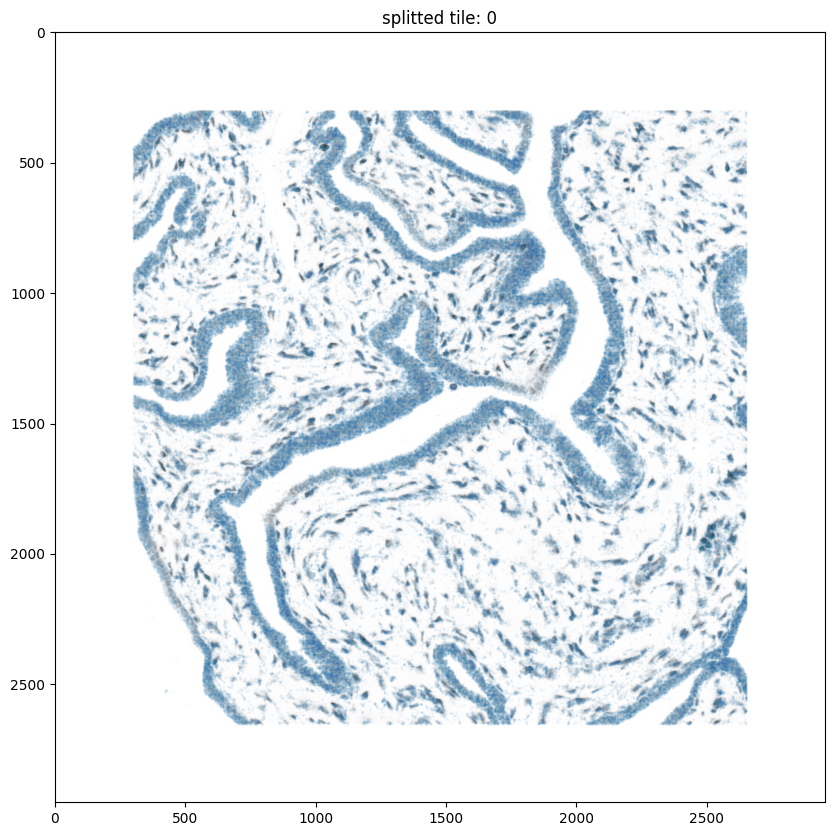

In [40]:
tile_num = 0
plt.figure(figsize=(10,10))
plt.imshow(out.loc[tile_num,'img'],cmap='Greys')

plt.scatter(
    out.loc[tile_num,'spots']['spot_location_1'],
    out.loc[tile_num,'spots']['spot_location_2'],
    s=0.1, alpha=0.1
)
plt.title(f'splitted tile: {tile_num}')
plt.show()

### cell segmentation on each tile

In [41]:
# non_empty_tiles = [i for i in range(out.shape[0]) if out.loc[i, 'spots'].shape[0] > 100]

In [43]:
def get_clustermap_tile(
        out, tile_num, min_spot_per_cell: int = 5,
        gene_list: list = None, num_dims: int = 2, xy_radius: int = 0
    ):
    from ClusterMap.clustermap import ClusterMap

    spots_tile=out.loc[tile_num,'spots']
    dapi_tile=out.loc[tile_num,'img']

    ### instantiate model
    return ClusterMap(
        spots=spots_tile, dapi=dapi_tile, gene_list=gene_list, num_dims=num_dims,
        xy_radius=xy_radius,z_radius=0,fast_preprocess=False
    )

# def test_model(model):
#     spots_array = np.array(model.spots.loc[:, ['spot_location_2', 'spot_location_1']])
#     return model.dapi_binary[list(spots_array[:,0]-1),list(spots_array[:,1]-1)]


def segment_clustermap_tile(model_tile, min_spot_per_cell: int = 5):
    model_tile.preprocess(dapi_grid_interval=3, pct_filter=0)
    model_tile.min_spot_per_cell = min_spot_per_cell
    model_tile.segmentation(cell_num_threshold=0.1,dapi_grid_interval=3,add_dapi=True,use_genedis=True)

    return model_tile

In [ ]:
%%time
tile_models = Parallel(n_jobs=70)(
    delayed(get_clustermap_tile)(
        out, tile_num, gene_list=gene_list, num_dims=num_dims, xy_radius=xy_radius
    ) for tile_num in non_empty_tiles[:10]
)

In [ ]:
%%time
tile_models_proc = Parallel(n_jobs=70)(
    delayed(segment_clustermap_tile)(tile) for tile in tile_models
)

In [ ]:
model.spots['clustermap'] = -1
for tile_num in range(out.shape[0]):
    model.stitch(tile_models[tile_num],out,tile_num)

In [ ]:
model.plot_segmentation(figsize=(20,10),s=0.05,plot_with_dapi=False,plot_dapi=True, show=False)
plt.scatter(model.cellcenter_unique[:,1],model.cellcenter_unique[:,0],c='r',s=10)